<a href="https://colab.research.google.com/github/SneK152/GU_Net_Glioma_Segmentation_SRA/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Conv2DBlock(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=5, padding=2, bias=True),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=False),
            nn.Conv2d(mid_channels, out_channels, kernel_size=7, padding=3, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=False)
        )

        def init_weights(m):
          if type(m) == nn.Conv2d:
            nn.init.xavier_normal_(m.weight)

        self.double_conv.apply(init_weights)

    def forward(self, x):
        return self.double_conv(x)

class ES(nn.Module):
  def __init__(self, input_channels, out_channels):
    super(ES, self).__init__()
    self.conv1 = nn.Conv2d(input_channels, out_channels, kernel_size=(15, 1), padding=(7, 0))
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(1, 15), padding=(0, 7))

    self.conv3 = nn.Conv2d(input_channels, out_channels, kernel_size=(13, 1), padding=(6, 0))
    self.conv4 = nn.Conv2d(out_channels, out_channels, kernel_size=(1, 13), padding=(0, 6))

    self.conv5 = nn.Conv2d(input_channels, out_channels, kernel_size=(11, 1), padding=(5, 0))
    self.conv6 = nn.Conv2d(out_channels, out_channels, kernel_size=(1, 11), padding=(0, 5))

    self.conv7 = nn.Conv2d(input_channels, out_channels, kernel_size=(9, 1), padding=(4, 0))
    self.conv8 = nn.Conv2d(out_channels, out_channels, kernel_size=(1, 9), padding=(0, 4))


    self.conv9 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=1)
    self.conv10 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=1)

    self.conv11 = nn.Conv2d(input_channels, out_channels, kernel_size=(1, 1), padding=0)

    self.outconv = nn.ReLU(inplace=False)

    nn.init.xavier_normal_(self.conv1.weight)
    nn.init.xavier_normal_(self.conv2.weight)
    nn.init.xavier_normal_(self.conv3.weight)
    nn.init.xavier_normal_(self.conv4.weight)
    nn.init.xavier_normal_(self.conv5.weight)
    nn.init.xavier_normal_(self.conv6.weight)
    nn.init.xavier_normal_(self.conv7.weight)
    nn.init.xavier_normal_(self.conv8.weight)
    nn.init.xavier_normal_(self.conv9.weight)
    nn.init.xavier_normal_(self.conv10.weight)
    nn.init.xavier_normal_(self.conv11.weight)

  def forward(self, x):
    x1 = self.conv2(self.conv1(x))
    x2 = self.conv4(self.conv3(x))
    x3 = self.conv6(self.conv5(x))
    x4 = self.conv8(self.conv7(x))
    xadd = torch.add(x1, x2)
    xadd = torch.add(xadd, x3)
    xadd = torch.add(xadd, x4)

    xskip = self.conv11(x)

    xout = torch.cat([xadd, xskip], dim=1)
    return self.outconv(xout)


class WC(nn.Module):
  def __init__(self, input_channels, out_channels, kernel_size, mid_channels):
    super(WC, self).__init__()
    self.conv1 = nn.Conv2d(input_channels, mid_channels, kernel_size=(kernel_size, 1), padding=(kernel_size // 2, 0))
    self.conv2 = nn.Conv2d(mid_channels, out_channels, kernel_size=(1, kernel_size), padding=(0, kernel_size // 2))

    self.conv3 = nn.Conv2d(input_channels, mid_channels, kernel_size=(1, kernel_size), padding=(0, kernel_size // 2))
    self.conv4 = nn.Conv2d(mid_channels, out_channels, kernel_size=(kernel_size, 1), padding=(kernel_size // 2, 0))

    nn.init.xavier_normal_(self.conv1.weight)
    nn.init.xavier_normal_(self.conv2.weight)
    nn.init.xavier_normal_(self.conv3.weight)
    nn.init.xavier_normal_(self.conv4.weight)

  def forward(self, x):
    x1 = self.conv1(x)
    x1 = self.conv2(x1)

    x2 = self.conv3(x)
    x2 = self.conv4(x2)

    return torch.add(x1, x2)


class BUNet(nn.Module):
    """Class to define the GU_Net Model"""

    def __init__(self, dropout):
        super(BUNet, self).__init__()

        self.c0 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.bn0 = nn.BatchNorm2d(16)
        self.relu0 = nn.ReLU(inplace=False)

        nn.init.xavier_normal_(self.c0.weight)

        self.c3 = Conv2DBlock(16, 64)
        self.c3_2 = Conv2DBlock(64, 96)
        self.p3 = nn.AvgPool2d(kernel_size=2)

        self.c4 = Conv2DBlock(96, 96)
        self.c4_2 = Conv2DBlock(96, 128)
        self.p4 = nn.AvgPool2d(kernel_size=2)

        self.c5 = Conv2DBlock(128, 96)
        self.c5_2 = Conv2DBlock(96, 128)
        self.c6 = Conv2DBlock(128, 64)
        self.c6_2 = Conv2DBlock(64, 128)

        # Transition
        self.ctr = WC(128, 512, mid_channels=256, kernel_size=11)

        # Expanding Path
        self.u6 = nn.ConvTranspose2d(512, 256, stride=2, output_padding=1, kernel_size=3, padding=1)
        self.c4_es = ES(128, 128)
        self.c6_up = Conv2DBlock(512, 256)

        nn.init.xavier_normal_(self.u6.weight)

        self.u7 = nn.ConvTranspose2d(256, 256, stride=2, output_padding=1, kernel_size=3, padding=1)
        self.c3_es = ES(96, 128)
        self.c7_up = Conv2DBlock(512, 64)

        nn.init.xavier_normal_(self.u7.weight)

        self.outputs = nn.Conv2d(64, 1, kernel_size=1)


    def forward(self, input_img):
        # Contracting Path
        c0 = self.c0(input_img)
        c0 = self.bn0(c0)
        c0 = self.relu0(c0)

        c3 = self.c3(c0)
        c3 = self.c3_2(c3)
        p3 = self.p3(c3)

        c4 = self.c4(p3)
        c4 = self.c4_2(c4)
        p4 = self.p4(c4)

        c5 = self.c5(p4)
        c5 = self.c5_2(c5)
        c6 = self.c6(c5)
        c6 = self.c6_2(c6)

        # Transition
        ctr = self.ctr(c6)

        # Expanding Path
        u6 = self.u6(ctr)
        c4_es = self.c4_es(c4)
        u6 = torch.cat((u6, c4_es), dim=1)
        c6_up = self.c6_up(u6)

        u7 = self.u7(c6_up)
        c3_es = self.c3_es(c3)
        u7 = torch.cat((u7, c3_es), dim=1)
        c7_up = self.c7_up(u7)

        outputs = self.outputs(c7_up)
        return outputs


In [ ]:
import os
import gc
import pandas as pd
from torch import device
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import numpy as np
import torch.nn as nn
import torch
import nibabel as nib

d_url = "/content/drive/MyDrive/SRA Research Project/BraTS 2021 Training Dataset v2"


class MyDataset(Dataset):
    def __init__(self, dirlist: list[str], device):
        def preprocess(image: np.ndarray, threshold=False, slice=0):
          image = image[:, :, (image.shape[2]//2)+slice]
          image = image - np.min(image)
          image = image / np.max(image)
          image = np.clip(image, 0, 1)
          image = np.nan_to_num(image)
          if threshold:
            image[image < 0.2] = 0
            image[image >= 0.2] = 1
          else:
            image[image < 0.3] = 0
          return image
        self.images = []
        self.seglabels = []
        self.device = device
        for i, dir in enumerate(dirlist):
            print(i+1, "/", len(dirlist))
            for j in range(-1, 2):
                # image = nib.load(os.path.join(d_url, dir, dir+"_flair.nii.gz")).get_fdata()
                # image = transforms.ToTensor()(np.rot90(preprocess(image, slice=j), i % 4).copy()).to(self.device)
                image = torch.load(os.path.join(d_url, dir, f"input_{j}.pt")).to(device)
                self.images.append(image)
                # torch.save(image, os.path.join(d_url, dir, f"input_{j}.pt"))
                # seg = nib.load(os.path.join(d_url, dir, dir+"_seg.nii.gz")).get_fdata()
                # seg = transforms.ToTensor()(np.rot90(preprocess(seg, True, slice=j), i % 4).copy()).to(self.device)
                seg = torch.load(os.path.join(d_url, dir, f"label_{j}.pt")).to(device)
                # torch.save(seg, os.path.join(d_url, dir, f"label_{j}.pt"))
                self.seglabels.append(seg)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        seglabel = self.seglabels[index]
        return image.to(self.device), seglabel.to(self.device)

    def collate_fn(self, batch):
        images = [item[0] for item in batch]
        target = [item[1] for item in batch]
        images = torch.stack(images, dim=0)
        target = torch.stack(target, dim=0)
        return images, target


def preprocess(tensor: torch.Tensor, threshold=False):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    tensor = tensor.clip(0,1)
    tensor = tensor.nan_to_num()
    if threshold:
      tensor[tensor < 0.2] = 0
      tensor[tensor >= 0.2] = 1
    else:
      tensor[tensor < 0.3] = 0
    return tensor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


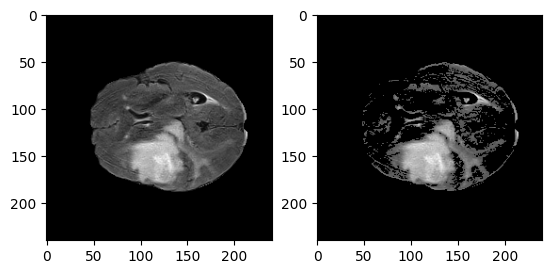

In [ ]:
# visualize the data
dir = "BraTS2021_01225"
image_old = nib.load(os.path.join(d_url, dir, dir+"_flair.nii.gz")).get_fdata()
image_old = image_old[:, :, image_old.shape[2]//2]
image = image_old - np.min(image_old)
image = image / np.max(image)
image = np.clip(image, 0, 1)
t_value = 0.32
image[image < t_value] = 0
# image[t_value <= image and image < t_value*2] = 1

plt.subplot(1,2,2)
plt.imshow(image, cmap="gray")
plt.subplot(1,2,1)
# seg = nib.load(os.path.join(d_url, dir, dir+"_seg.nii.gz")).get_fdata()
# plt.imshow(np.rot90(seg[:, :, seg.shape[2]//2], 1).copy(), cmap="gray")
plt.imshow(image_old, cmap="gray")

In [ ]:
from torch.utils.data import random_split
import os
import gc
import torch
import matplotlib.pyplot as plt

gc.collect()
torch.cuda.empty_cache()

train_dir = []
val_dir = []
test_dir = []

dataset = os.listdir(d_url)
print(len(dataset))

device = torch.device("cuda")

train, val, test, _ = random_split(dataset, [0.40, 0.05, 0.05, 0.50], torch.Generator().manual_seed(43))
for i in range(0, len(dataset)):
  if i in train.indices:
    train_dir.append(dataset[i])
  elif i in val.indices:
    val_dir.append(dataset[i])
  elif i in test.indices:
    test_dir.append(dataset[i])
gc.collect()

train_set = MyDataset(train_dir, device)
train_loader = DataLoader(train_set, batch_size=8,
                           shuffle=True, num_workers=0, collate_fn=train_set.collate_fn)

val_set = MyDataset(val_dir, device)
val_loader = DataLoader(val_set, batch_size=1,
                           shuffle=True, num_workers=0, collate_fn=val_set.collate_fn)
test_set = MyDataset(test_dir, device)
test_loader = DataLoader(test_set, batch_size=1,
                           shuffle=True, num_workers=0, collate_fn=test_set.collate_fn)

1098
1 / 8
2 / 8
3 / 8
4 / 8
5 / 8
6 / 8
7 / 8
8 / 8


In [ ]:
def dice_coefficient(inputs, targets, smooth=1e-5):

  inputs = F.sigmoid(inputs)

  inputs = inputs.view(-1)
  targets = targets.view(-1)

  intersection = (inputs * targets).sum()
  dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

  return dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-5):

        inputs = F.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = nn.BCEWithLogitsLoss()(inputs, targets)

        Dice_BCE = 0.1*BCE + 0.9*dice_loss

        return Dice_BCE
def iou(inputs, targets, smooth=1e-5):

    inputs = F.sigmoid(inputs)

    inputs = inputs.view(-1)
    targets = targets.view(-1)

    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection

    IoU = (intersection + smooth)/(union + smooth)

    return IoU

In [ ]:
gc.collect()
torch.cuda.empty_cache()
device = torch.device("cuda")
model = BUNet(0.1).to(device)

env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/SRA Research Project/novel_net_data_2.pt"))

FileNotFoundError: ignored

In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
loss_func = DiceBCELoss()

model.train()
train_losses = []
val_losses = []
best_acc = 0.75

for epoch in range(10):
  gc.collect()
  torch.cuda.empty_cache()
  print("EPOCH # " + str(epoch+1))

  total = 0
  t_losses = []
  v_losses = []
  metrics = {
      "dice": [],
      "iou": []
  }

  for batch in train_loader:
      gc.collect()
      torch.cuda.empty_cache()
      optimizer.zero_grad()

      inp, labels = batch
      inp, labels = inp.to(device).type(torch.cuda.FloatTensor), labels.to(device).type(torch.cuda.FloatTensor)


      out = model(inp)
      loss = loss_func(out, labels)

      loss.backward()
      optimizer.step()

      total += 1
      t_losses.append(loss.item())
      print('[%d, %5d] loss: %.3f dice: %.3f iou: %.3f' % (epoch + 1, total, loss.item(), dice_coefficient(out, labels), iou(out, labels)))

  train_losses.append(sum(t_losses)/len(t_losses))

  gc.collect()
  torch.cuda.empty_cache()
  model.eval()

  with torch.no_grad():
      for data in val_loader:
          gc.collect()
          torch.cuda.empty_cache()
          inp, labels = data
          inp = inp.to(device).type(torch.cuda.FloatTensor)
          labels = labels.to(device).type(torch.cuda.FloatTensor)

          target = model(inp)
          lo = loss_func(target, labels)

          v_losses.append(lo.item())
          metrics["dice"].append(dice_coefficient(target, labels).item())
          metrics["iou"].append(iou(preprocess(target), preprocess(labels, True)).item())


  val_losses.append(sum(v_losses)/len(v_losses))
  model.train()
  gc.collect()
  torch.cuda.empty_cache()

  print("Avg IOU on validiation images:",sum(metrics["iou"])/len(metrics["iou"]))
  print("Avg Dice Coefficient on validiation images:",sum(metrics["dice"])/len(metrics["dice"]))
  if sum(metrics["dice"])/len(metrics["dice"]) > best_acc:
    best_acc = sum(metrics["dice"])/len(metrics["dice"])
    print("saving...")
    torch.save(model.state_dict(), "/content/drive/MyDrive/SRA Research Project/novel_net_data_3.pt")



EPOCH # 1
[1,     1] loss: 0.176 dice: 0.881 iou: 0.787
[1,     2] loss: 0.396 dice: 0.637 iou: 0.467
[1,     3] loss: 0.222 dice: 0.830 iou: 0.709
[1,     4] loss: 0.266 dice: 0.781 iou: 0.640
[1,     5] loss: 0.260 dice: 0.787 iou: 0.649
[1,     6] loss: 0.238 dice: 0.812 iou: 0.684
[1,     7] loss: 0.225 dice: 0.826 iou: 0.704
[1,     8] loss: 0.189 dice: 0.866 iou: 0.764
[1,     9] loss: 0.231 dice: 0.820 iou: 0.695
[1,    10] loss: 0.382 dice: 0.653 iou: 0.484
[1,    11] loss: 0.472 dice: 0.553 iou: 0.382
[1,    12] loss: 0.391 dice: 0.642 iou: 0.473
[1,    13] loss: 0.263 dice: 0.785 iou: 0.646
[1,    14] loss: 0.273 dice: 0.773 iou: 0.630
[1,    15] loss: 0.185 dice: 0.871 iou: 0.771
[1,    16] loss: 0.226 dice: 0.825 iou: 0.702
[1,    17] loss: 0.242 dice: 0.808 iou: 0.678
[1,    18] loss: 0.222 dice: 0.829 iou: 0.708
[1,    19] loss: 0.181 dice: 0.875 iou: 0.778
[1,    20] loss: 0.163 dice: 0.894 iou: 0.809
[1,    21] loss: 0.261 dice: 0.787 iou: 0.649
[1,    22] loss: 0.382 d

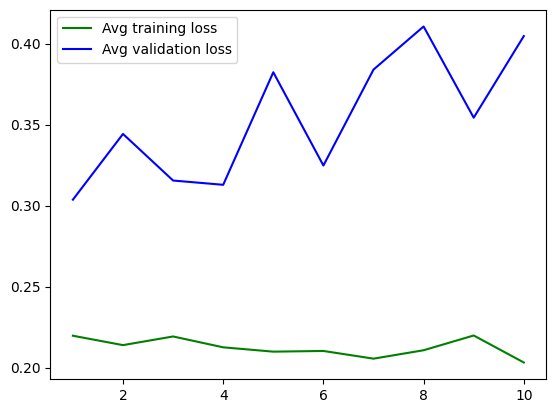

In [ ]:
epochs = range(1, len(train_losses) + 1)
# print(val_los ses)
plt.plot(epochs, train_losses, 'g', label='Avg training loss')
plt.plot(epochs, val_losses, 'b', label='Avg validation loss')
plt.legend()

In [ ]:
avg_dice = []
avg_iou = []

new_model = BUNet(0.1).to(device)
new_model.load_state_dict(torch.load("/content/drive/MyDrive/SRA Research Project/novel_net_data_3.pt"))

with torch.no_grad():
  for data in test_loader:
    gc.collect()
    torch.cuda.empty_cache()
    inp, labels = data
    inp = inp.to(device).type(torch.cuda.FloatTensor)
    labels = labels.to(device).type(torch.cuda.FloatTensor)

    target = new_model(inp)

    avg_dice.append(dice_coefficient(target, labels).item())
    avg_iou.append(iou(target, labels).item())

print("Avg Dice Coefficient for Test Data:",sum(avg_dice)/len(avg_dice))
print("Avg IOU Score for Test Data:",sum(avg_iou)/len(avg_iou))

Avg Dice Coefficient for Test Data: 0.7158092022212285
Avg IOU Score for Test Data: 0.6128934790320495


[3.8924991e-06 4.0860864e-06 4.7788922e-06 ... 9.9998724e-01 9.9998808e-01
 9.9998927e-01]


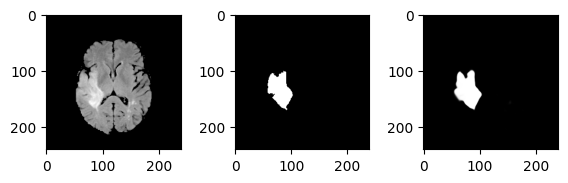

In [ ]:
l = list(test_loader)


t = F.sigmoid(model(l[0][0].type(torch.cuda.FloatTensor))).cpu().detach().numpy()
print(np.unique(t))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.subplot(1,3,3)
plt.imshow(t.squeeze(), cmap="gray")
plt.subplot(1,3,1)
plt.imshow(l[0][0].cpu().detach().numpy().squeeze(), cmap="gray")
plt.subplot(1,3,2)
plt.imshow(l[0][1].cpu().detach().numpy().squeeze(), cmap="gray")